# Image Segmentation:
- Unet model and combine with transfer learning from VGG-16
- Data is trained on in-built dataset: "Oxford_iiit_pet"
- Perfrom both sementic, instance and phenoptic segmentation

# Here only sementic segemnetation is being tested.

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_datasets as tfds

In [14]:
# Load the Oxford-IIIT Pet dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', split='train', shuffle_files=True, with_info=True)

# Determine the number of classes in the segmentation mask
num_classes = info.features['segmentation_mask'].shape[-1]
print(num_classes)
print(info.features)

# Prepare the dataset for training
def preprocess(example):
    image = tf.image.resize(example['image'], (256, 256))
    mask = tf.image.resize(example['segmentation_mask'], (256, 256))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

dataset = dataset.map(preprocess)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

1
FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [15]:
# Separate input features (images) and labels (masks)
input_images = []
labels = []

for image, mask in dataset:
    input_images.append(image)
    labels.append(mask)

input_images = tf.concat(input_images, axis=0)
labels = tf.concat(labels, axis=0)

# Print the shapes of input images and labels
print("Input Images shape:", input_images.shape)
print("Labels shape:", labels.shape)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Input Images shape: (3680, 256, 256, 3)
Labels shape: (3680, 256, 256, 1)


In [17]:
# Load the pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the VGG16 layers
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

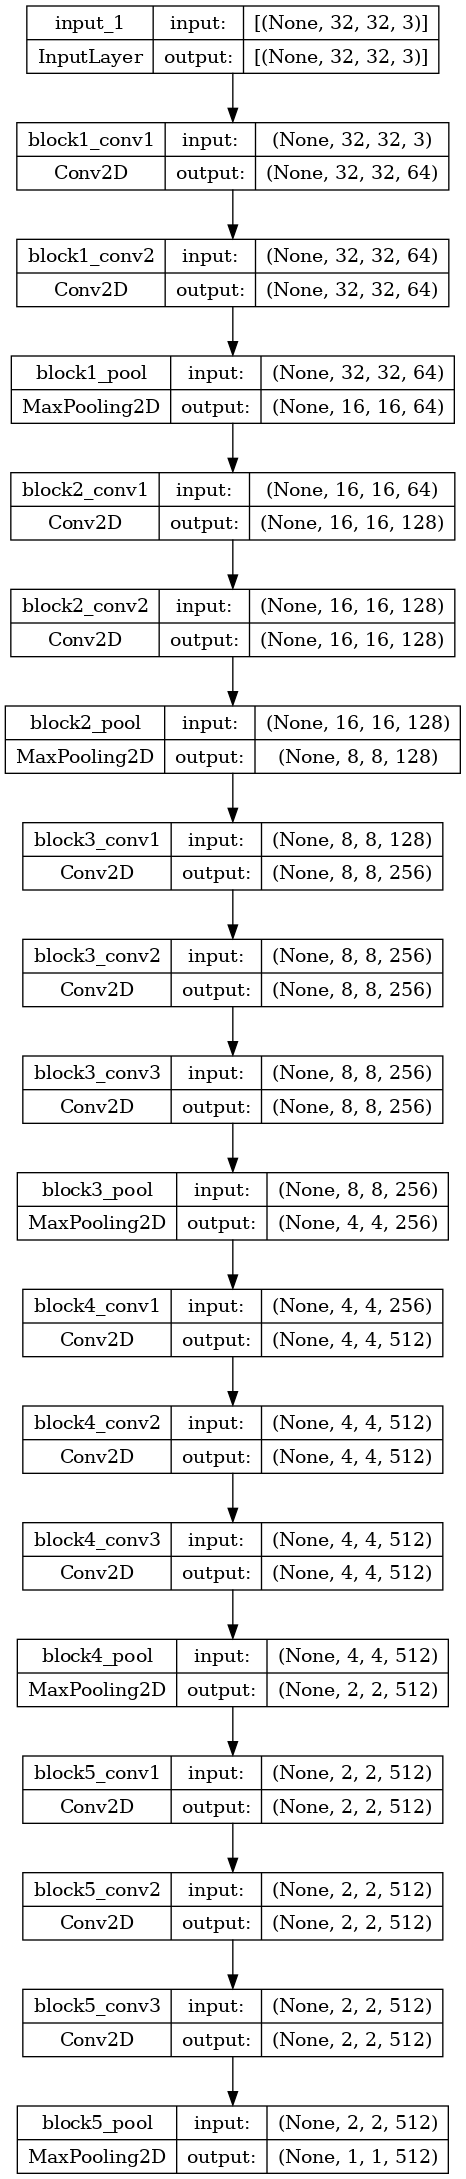

In [9]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [22]:
# # Build the U-Net model on top of VGG16
# conv_layers = base_model.get_layer('block5_conv3').output

# x = Conv2D(1024, 3, activation='relu', padding='same')(conv_layers)
# x = Conv2D(1024, 3, activation='relu', padding='same')(x)
# x = Conv2DTranspose(512, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block4_conv3').output])
# x = Conv2D(512, 3, activation='relu', padding='same')(x)
# x = Conv2D(512, 3, activation='relu', padding='same')(x)
# x = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block3_conv3').output])
# x = Conv2D(256, 3, activation='relu', padding='same')(x)
# x = Conv2D(256, 3, activation='relu', padding='same')(x)
# x = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block2_conv2').output])
# x = Conv2D(128, 3, activation='relu', padding='same')(x)
# x = Conv2D(128, 3, activation='relu', padding='same')(x)
# x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
# x = Concatenate()([x, base_model.get_layer('block1_conv2').output])
# x = Conv2D(64, 3, activation='relu', padding='same')(x)
# x = Conv2D(64, 3, activation='relu', padding='same')(x)
# output = Conv2D(1, 1, activation='sigmoid')(x)

# # Create the segmentation model
# model = Model(inputs=base_model.input, outputs=output)

# model.summary()

In [18]:
# Use the activations of these layers
layer_names = [
    'block2_conv1',   # 64x64
    'block3_conv1',   # 32x32
    'block4_conv1',   # 16x16
    'block5_conv1',  # 8x8
    'block5_pool',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [19]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

**Train the Model**
Now let's compile the model and see the model architecture

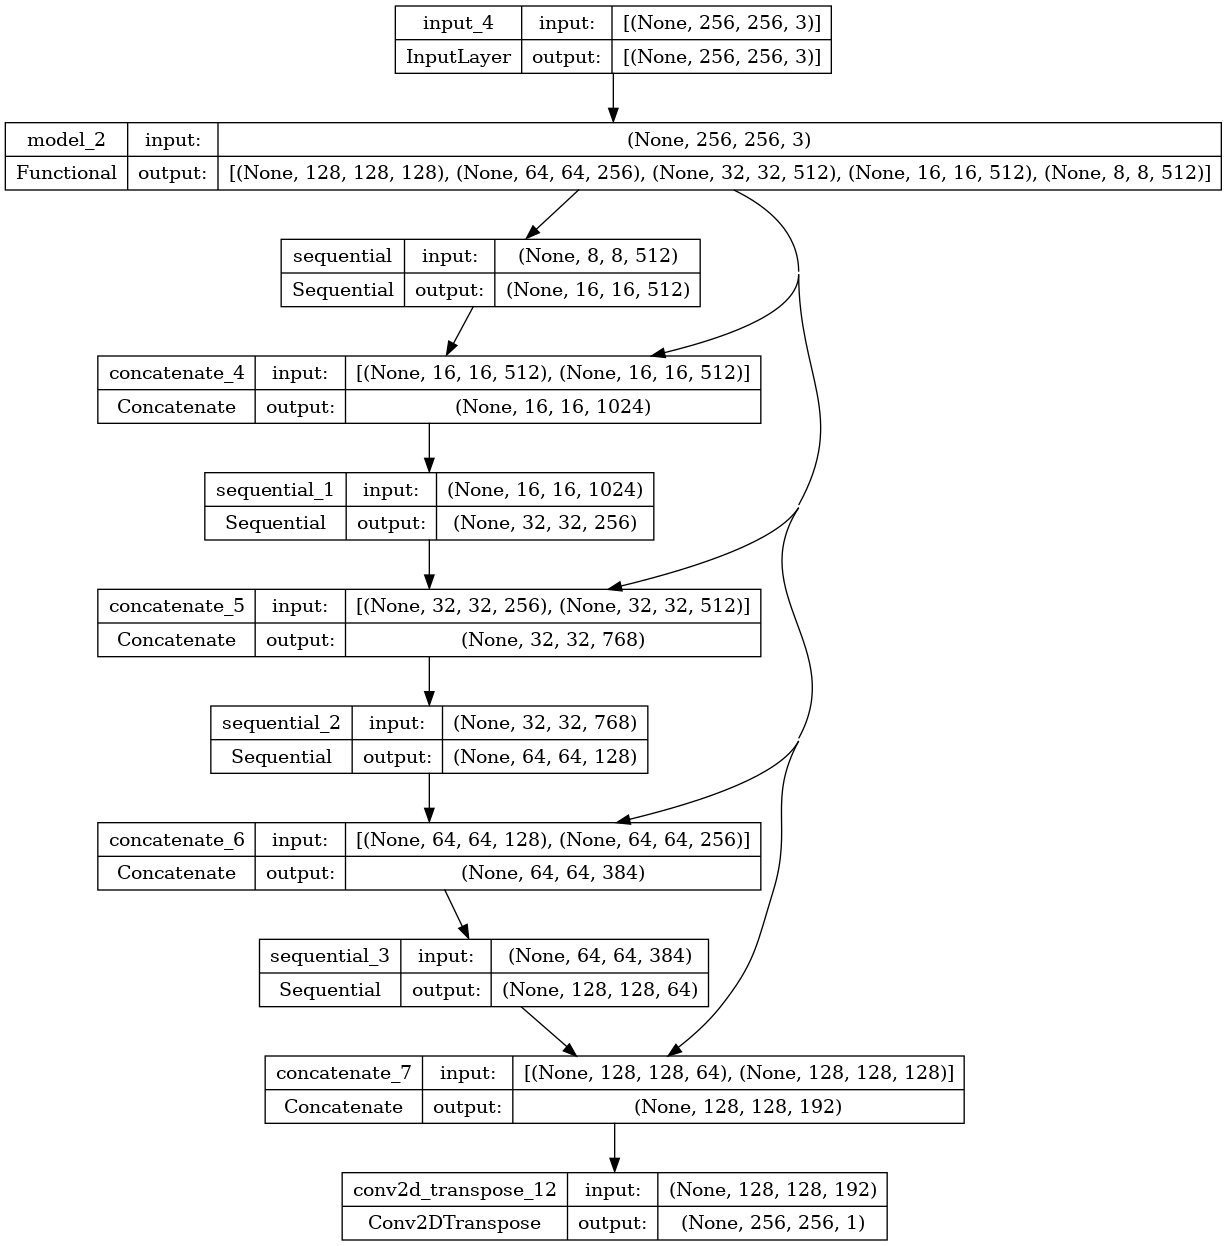

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 341ms/step


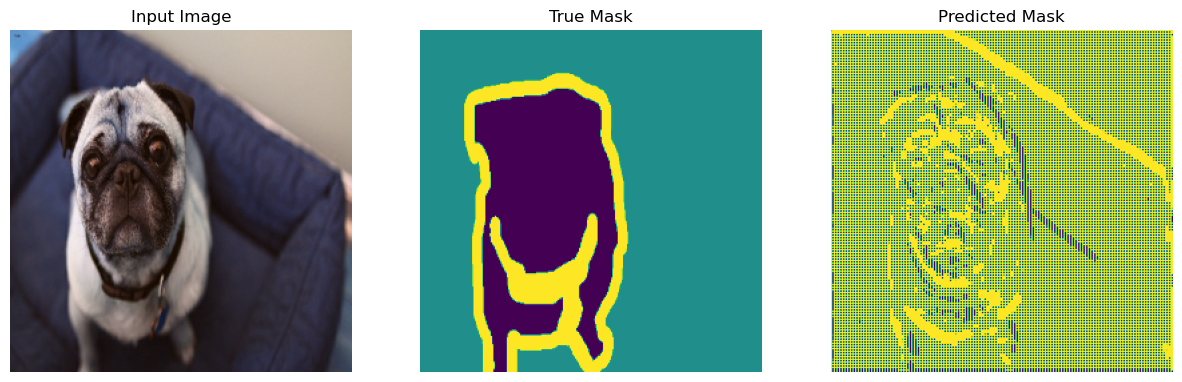

In [27]:
img_size = [256,256]
for images, masks in dataset:
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

Epoch 1/15
5/5 [==============================] - 63s 12s/step - loss: 0.9859 - dice_coef: 0.0141 - binary_accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 0s 332ms/step


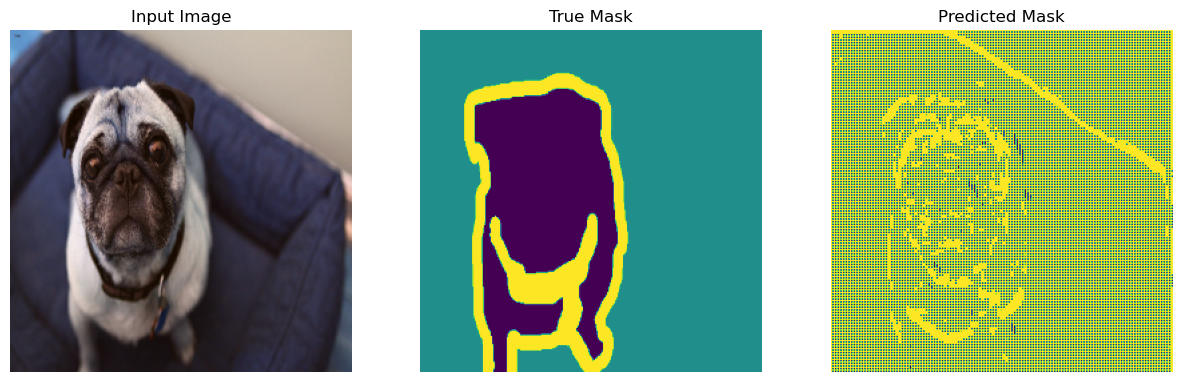

Epoch 3/15
5/5 [==============================] - 61s 12s/step - loss: 0.9859 - dice_coef: 0.0141 - binary_accuracy: 0.0000e+00
Epoch 4/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1/5 [=====>........................] - ETA: 49s - loss: 0.9862 - dice_coef: 0.0138 - binary_accuracy: 0.0000e+00

Corrupt JPEG data: premature end of data segment


5/5 [==============================] - 62s 12s/step - loss: 0.9859 - dice_coef: 0.0141 - binary_accuracy: 0.0000e+00
Epoch 5/15
1/1 [==============================] - 0s 324ms/step


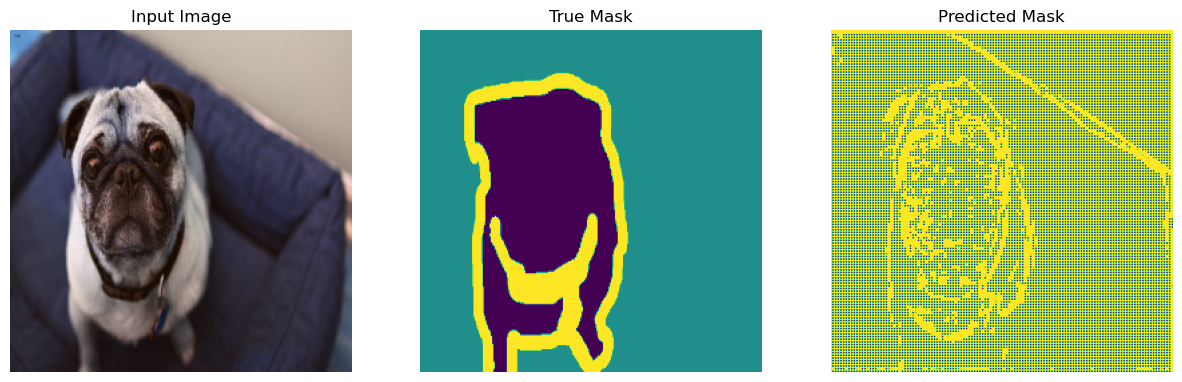

Epoch 6/15
5/5 [==============================] - 62s 12s/step - loss: 0.9856 - dice_coef: 0.0144 - binary_accuracy: 0.0000e+00
Epoch 7/15
5/5 [==============================] - 61s 12s/step - loss: 0.9858 - dice_coef: 0.0142 - binary_accuracy: 0.0000e+00
Epoch 8/15
1/1 [==============================] - 0s 334ms/step


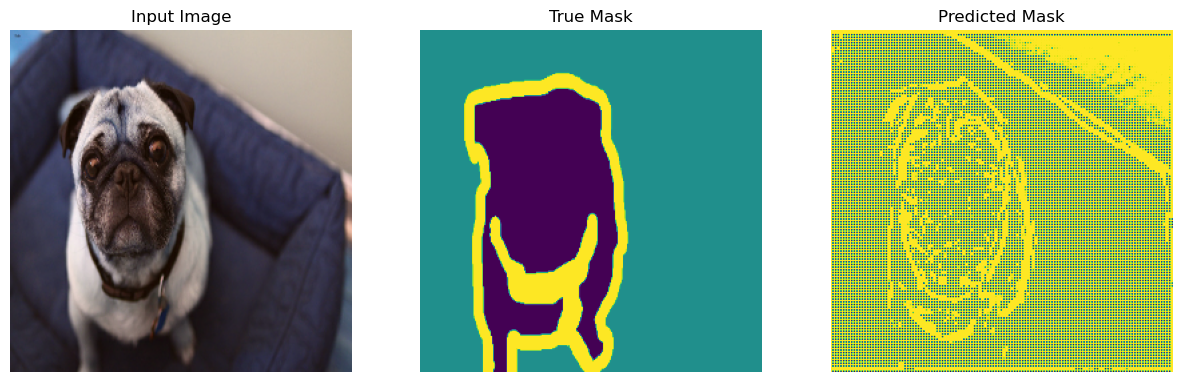

Epoch 9/15
5/5 [==============================] - 61s 12s/step - loss: 0.9858 - dice_coef: 0.0142 - binary_accuracy: 0.0000e+00
Epoch 10/15
5/5 [==============================] - 63s 13s/step - loss: 0.9859 - dice_coef: 0.0141 - binary_accuracy: 0.0000e+00
Epoch 11/15
1/1 [==============================] - 0s 361ms/step


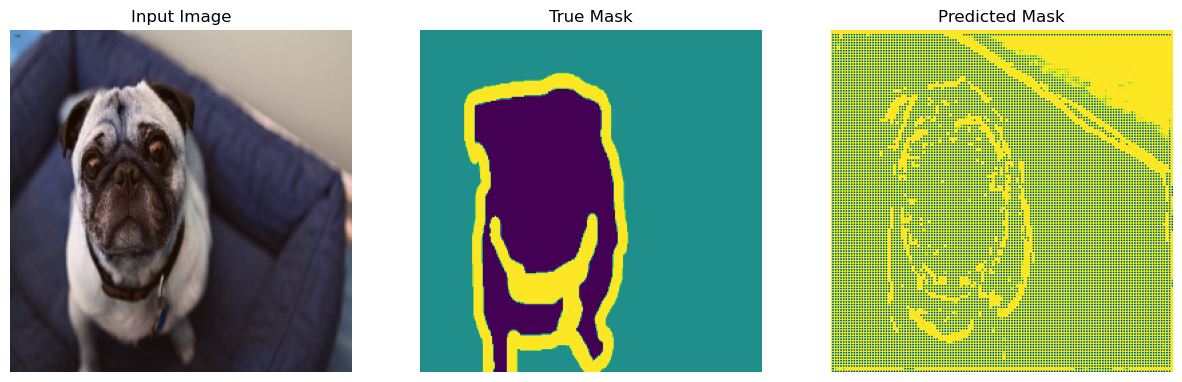

Epoch 12/15
5/5 [==============================] - 69s 14s/step - loss: 0.9857 - dice_coef: 0.0143 - binary_accuracy: 0.0000e+00
Epoch 14/15
1/1 [==============================] - 0s 349ms/step


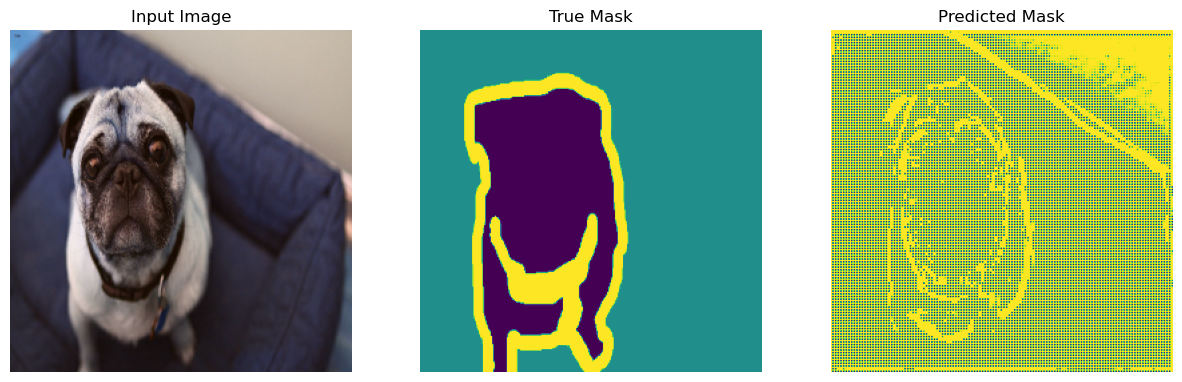

Epoch 15/15
5/5 [==============================] - 68s 13s/step - loss: 0.9857 - dice_coef: 0.0143 - binary_accuracy: 0.0000e+00


In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 15
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(dataset, epochs=EPOCHS,
                          steps_per_epoch=5,
                          callbacks=[DisplayCallback(), early_stop])

In [31]:
# Save the trained model
model.save('second_unet__segmentation.h5')